1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

The global minimum of the function is at  [0. 0.]
The function value at its global minimum is  0.0


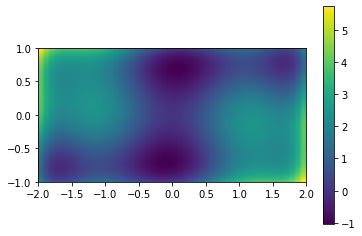

<Figure size 432x288 with 0 Axes>

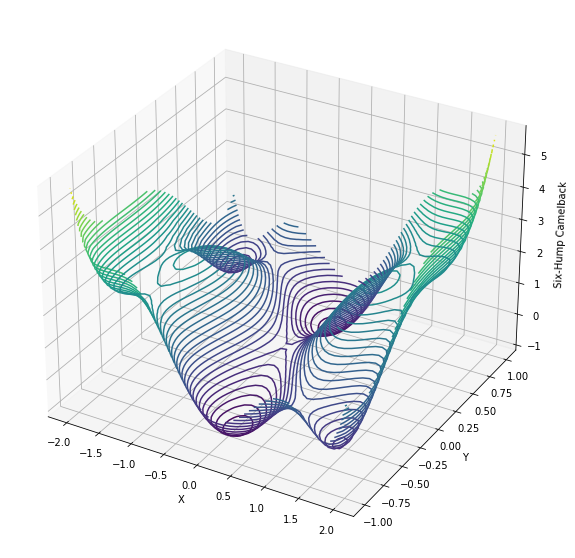

In [4]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
def func(x,y):
    return (4-2.1*x**2 + x**4/3)*x**2 + x*y + (4*y**2 -4)*y**2
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
x_grid, y_grid = np.meshgrid(x,y)

plt.imshow(func(x_grid,y_grid), extent=[-2, 2, -1, 1])
plt.colorbar()


 
def function(X):
    return ((4 - 2.1*X[0]**2 + X[0]**4 / 3.) * X[0]**2 + X[0] * X[1]+ (-4 + 4*X[1]**2) * X[1] **2)

x_min =minimize(function, x0=[0, 0],bounds=[[-2,2],[-1,1]])
print("The global minimum of the function is at ",x_min.x)
print("The function value at its global minimum is ",x_min.fun)


fig = plt.figure()
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(x_grid, y_grid, func(x_grid, y_grid),50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Six-Hump Camelback')
plt.show()


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

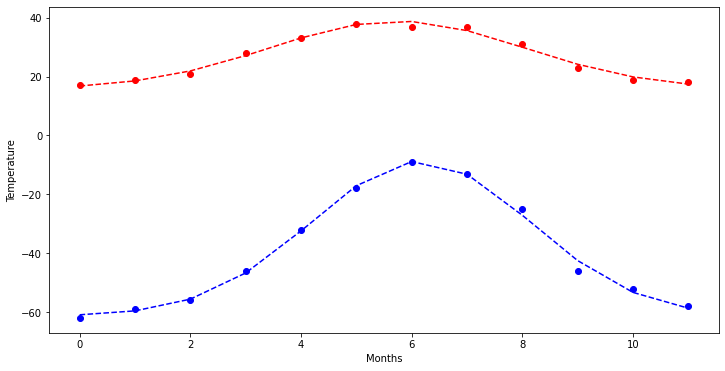

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

max_T=[17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_T=[-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months = np.arange(len(max_T))
plt.figure(figsize=(12,6))
plt.plot(months,max_T,"ro",months, min_T,"bo")
plt.xlabel("Months")
plt.ylabel("Temperature")
def T_normal(x,a,b,sigma,mu):
    return  a+b*(1/sigma)*np.exp(-pow((x-mu),2)/(2*pow(sigma,2)))
params_max, params_max_cov = curve_fit(T_normal, months, max_T)
params_min, params_min_cov = curve_fit(T_normal, months, min_T)
plt.plot(months,T_normal(months,params_min[0],params_min[1],params_min[2],params_min[3]), 'b--')
plt.plot(months,T_normal(months,params_max[0],params_max[1],params_max[2],params_max[3]), 'r--')


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.